# MT3DMS - Case1

### Import Statement

In [1]:
import flopy
import flopy.modflow as mf
import flopy.utils as fu
import flopy.utils.binaryfile as bf
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import shutil
import sys
import datetime
import math
from sklearn.metrics import mean_squared_error as mse
import flopy.mt3d as mt3
from flopy.export import vtk
import itertools as it
%matplotlib inline

### Print versions

In [2]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.7 (v3.6.7:6ec5cf24b7, Oct 20 2018, 13:35:33) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.14.3
pandas version: 0.23.4
matplotlib version: 3.0.2
flopy version: 3.2.10


### Setup Packages and Directory

In [3]:
exe_name_mf = 'mf2005.exe'
exe_name_mt = 'mt3dms5b.exe'#'MT3D-USGS.exe'
datadir = os.path.join('.', 'inputdata', 'mt3d_test', 'mt3dms')
workdir = os.path.join('.', 'data')

In [4]:
def p03(dirname, mixelm):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 31
    ncol = 46
    delr = 10.02929
    delc = 10.13367
    delv = 10
    Lx = (ncol - 1) * delr
    v = 1. / 3.
    prsity = 0.3
    q = v * prsity
    al = 10.
    trpt = .3
    q0 = 1.
    c0 = 1000.

    perlen_mf = 365.
    perlen_mt = 365.
    hk = 1.
    laytyp = 0

    modelname_mf = dirname + '_mf'
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol,
                                   delr=delr, delc=delc, top=10, botm=[10 - delv],
                                   perlen=perlen_mf,
                                   proj4_str = 'EPSG:31985',
                                  )
   
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
    ibound[0, :, 0] = -1
    ibound[0, :, -1] = -1
    strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
    h1 = q * Lx
    strt[0, :, 0] = h1
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=[[0, 15, 15, q0]])
    
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = dirname + '_mt'
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=0)
    dceps = 1.e-5
    nplane = 1
    npl = 0
    nph = 16
    npmin = 2
    npmax = 32
    dchmoc=1.e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                                npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                                nlsink=nlsink, npsink=npsink, percel=0.5)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
    spd = {0:[0, 15, 15, c0, 2]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, 'MT3D001.OBS')
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, 'MT3D001.MAS')
    mvt = mt.load_mas(fname)
    return mf, mt, conc, cvt, mvt    

Text(0.5, 1.0, 'HMOC')

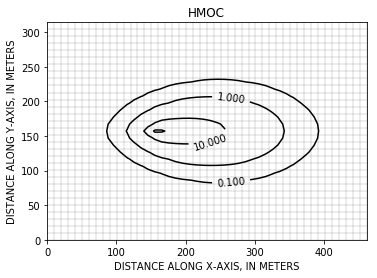

In [5]:
ax = plt.subplot(1, 1, 1, aspect='equal')
mf, mt, conc, cvt, mvt = p03('p03', 3)
conc = conc[0, :, :, :]
mm = flopy.plot.ModelMap(model=mf)
mm.plot_grid(color='.5', alpha=0.2)
cs = mm.contour_array(conc, levels=[0.1, 1., 10., 40.], colors='k')
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('HMOC')

Text(0.5, 1.0, 'ULTIMATE')

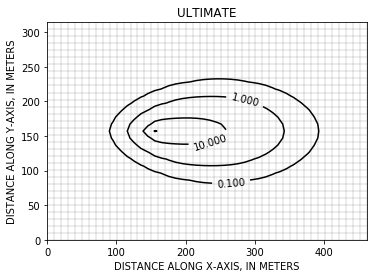

In [6]:
ax = plt.subplot(1, 1, 1, aspect='equal')
mf, mt, conc, cvt, mvt = p03('p03', -1)
conc = conc[0, :, :, :]
mm = flopy.plot.ModelMap(model=mf)
mm.plot_grid(color='.5', alpha=0.2)
cs = mm.contour_array(conc, levels=[0.1, 1., 10., 50.], colors='k')
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('ULTIMATE')